# JLS bibliometry

## Preparation

In [2]:
# Uncomment and run once
# if you use vanilla python:
#   !pip install py2neo python-dotenv pandas pyvis networkx plotly ipywidgets
# OR if you use anaconda:
#   !conda install -c conda-forge py2neo python-dotenv networkx plotly ipywidgets
#   !conda install panda pyvis
# for table of contents support, see https://github.com/ipython-contrib/jupyter_contrib_nbextensions

## Most published JLS authors (crossref.org)

In [2]:
query ="""
match (a:Author)-[:CREATOR_OF]->(w:Work)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
where w.url <> "" and a.display_name <> ""
return a.display_name as Author, count(distinct w) as PublicationCount
order by PublicationCount desc
limit 100
"""
from scripts.utils import get_graph
get_graph("jls2").run(query).to_data_frame()

,Author,PublicationCount
0,"cotterrell, roger",15
1,"campbell, d.",14
2,"cowan, d.",12
3,"wheeler, s.",12
4,"thomas, p.a.",10
...,...,...
95,"kelsey, jane",3
96,"sugarman, d.",3
97,"salter, michael",3
98,"mumford, ann",3


## Most-published authors, timeseries (crossref.org)

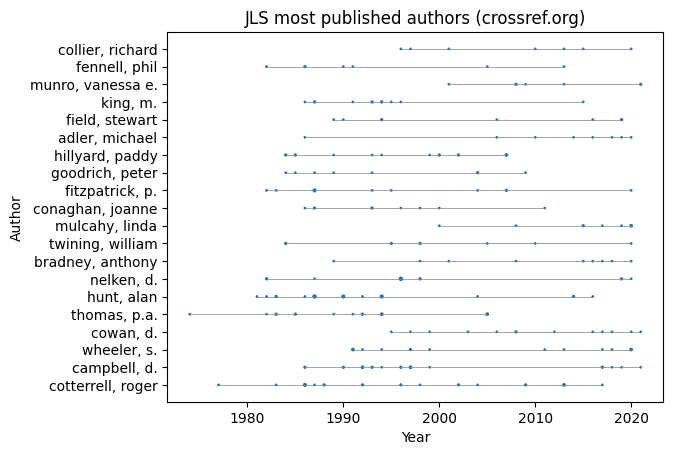

In [1]:
query ="""
match (a:Author)-[:CREATOR_OF]->(w:Work)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
where w.url <> "" and a.display_name <> ""
with a, count(distinct w) as count
order by count desc
limit 20
match (a)-[:CREATOR_OF]->(w:Work)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
return a.display_name as author,
    w.year as year,
    count(distinct w) as count
"""
from scripts.utils import get_graph
from scripts.occurrence_by_year_scatter import plot_by_year
data = get_graph("jls2").run(query).to_data_frame()
data.sort_values()
plot_by_year(data, dep_col='author', dep_label="Author",
             file="docs/jls-ts-most-published-authors.png",
             title="JLS most published authors (crossref.org)")

## Most-published authors with the authors they cite most (>2 citations, extraction data)

In [25]:
query = """
match (a1:Author)-[:CREATOR_OF]->(w:Work)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
where w.url <> "" and a1.display_name <> ""
    and w.year >= $year_start AND w.year <= $year_end
with a1, count(distinct w) as count
order by count desc
limit 20
set a1.value = count
set a1.label = (a1.display_name + "\n(" + toString(count) + " publications)")
with a1
match (a1)-[:CREATOR_OF]->(w1:Work)-[citation:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
where (w1)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
    and w1.year >= $year_start AND w1.year <= $year_end
    and a1 <> a2 and a2.display_name <> ""
with a1, a2, count(citation) as citCount
where citCount > 2
set a1.group = "citing"
set a2.group = "cited"
return a1,
    apoc.create.vRelationship(a1, 'CITES', {value: citCount, label:toString(citCount)}, a2),
    a2
"""
from scripts.pyvis import create_timeseries
from scripts.utils import get_graph
graph = get_graph("jls2")
create_timeseries(graph, query,
                  file_id="jls-most-published-with-cited-authors",
                  title="JLS most published authors with main cited authors")
graph.run("match (a:Author) remove a.value, a.label, a.group")

(No data)

## JLS top 10 most cited JLS authors of each decade with most-citing JLS authors (extraction data)

In [24]:
query = """
// find all JLS authors citing JLS authors for the given period
MATCH (citingAuthor:Author)-[:CREATOR_OF]->(:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
WHERE (citedWork)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
    AND citedWork.year >= $year_start AND citedWork.year <= $year_end
    AND citedAuthor.family <> "no_author" AND citingAuthor.family <> "no_author"
    AND citedAuthor.display_name <> "" and citingAuthor.display_name <> ""
    AND citingAuthor <> citedAuthor

// get the 10 most-cited authors and info on the citing authors
WITH citedAuthor, citingAuthor as citingAuthors, count(citation) as citationCount
ORDER BY citationCount DESC
WITH citedAuthor, collect({citingAuthor: citingAuthors, citationCount: citationCount}) as citingAuthorsInfo
LIMIT 10

// add the total citation count to the label and size the author node according to this ammount
call {
    with citedAuthor
    match (:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor)
    where citedWork.year >= $year_start AND citedWork.year <= $year_end
    with citedAuthor, count(citation) as citationCount
    set citedAuthor.label = (citedAuthor.display_name + "\n(" + toString(citationCount) + " citations)")
    set citedAuthor.value = citationCount
}

// get the 10 most-citing authors and size their node according to their own citation weight
UNWIND citingAuthorsInfo as citingAuthorInfo
WITH citedAuthor, citingAuthorInfo.citingAuthor as citingAuthor, citingAuthorInfo.citationCount as citationCount
ORDER BY citationCount DESC
call {
    with citingAuthor
    match (:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citingAuthor)
    where citedWork.year >= $year_start AND citedWork.year <= $year_end
    with citingAuthor, count(citation) as citationCount
    set citingAuthor.value = citationCount
}

WITH citedAuthor, collect({citingAuthor: citingAuthor, citationCount: citationCount})[..10] as topCitingAuthors
UNWIND topCitingAuthors as citingAuthorInfo

// count the number of citations between citing and cited author and create relationships
WITH citingAuthorInfo.citingAuthor AS citingAuthor, citedAuthor
MATCH path = (citingAuthor)-[:CREATOR_OF]->(:Work)-[:CITES]->(:Work)<-[:CREATOR_OF]-(citedAuthor)
WITH citingAuthor, citedAuthor, COUNT(path) AS pathCount

// assign groups for visual differentiation
SET citingAuthor.group = CASE WHEN exists(citingAuthor.group) THEN citingAuthor.group ELSE "citingAuthor" END
SET citedAuthor.group = "citedAuthor"

// return nodes and a virtual relationships between them
RETURN citingAuthor,
    apoc.create.vRelationship(citingAuthor, 'CITES', {value: pathCount, label:toString(pathCount)}, citedAuthor),
    citedAuthor
"""
from scripts.utils import get_graph
from scripts.pyvis import create_timeseries
graph = get_graph("jls2")
create_timeseries(graph, query,
                  file_id="jls-most-cited-with-most-citing",
                  title="JLS most-cited authors with most-citing JLS authors")
graph.run("match (a:Author) remove a.group, a.label")

(No data)

## Top 10 cited authors of each decade and the most influential citing JLS authors (extraction data)

In [4]:
query = """
// find the 30 most cited authors for all works with the id 'j law soc' (globalMostCited)
MATCH (a:Author)-[:CREATOR_OF]->(w:Work)<-[:CITES]-(w2:Work)-[:PUBLISHED_IN]->(v:Venue {id: 'j law soc'})
where a.family <> "no_author"
WITH a, COUNT(w2) AS citationCount
ORDER BY citationCount DESC
LIMIT 30
set a.value = citationCount
WITH collect(a) AS globalMostCited

// for all of the works published in the venue during that period (i.e., having a corresponding `year` property), determine the 10 most-cited authors (localMostCited)
MATCH (a2:Author)-[:CREATOR_OF]->(w3:Work)<-[citation:CITES]-(:Work)-[:PUBLISHED_IN]->(v2:Venue {id: 'j law soc'})
WHERE w3.year >= $year_start AND w3.year <= $year_end
    and a2.family <> "no_author"
WITH a2, COUNT(citation) AS localCitationCount, globalMostCited
ORDER BY localCitationCount DESC
LIMIT 10
set a2.value = localCitationCount
set a2.label = (a2.display_name + "\n(" + toString(localCitationCount) + " citations)")
WITH collect(a2) AS localMostCited, globalMostCited

// unroll both collections to a list of nodes
UNWIND globalMostCited AS gmc
UNWIND localMostCited AS lmc

// find citations between these nodes
MATCH path = (gmc)-[:CREATOR_OF]->(:Work)-[:CITES]->(:Work)<-[:CREATOR_OF]-(lmc)
where lmc <> gmc
set gmc.group = "gmc"
set lmc.group = "lmc"
WITH gmc, lmc, COUNT(path) AS pathCount

// create virtual relationships
CALL apoc.create.vRelationship(gmc, 'CITES', {value: pathCount, label:toString(pathCount)}, lmc) YIELD rel
RETURN gmc, lmc, rel

"""
from scripts.utils import get_graph
from scripts.pyvis import create_timeseries
graph = get_graph("jls2")
create_timeseries(graph, query,
                  file_id="jls-most-cited-with-most-cited-citers",
                  title="JLS most-cited authors with most-cited citing authors")
graph.run("match (a:Author) remove a.value, a.label, a.group")

(No data)

## Co-Citation network (extraction data)


In [3]:
query = """
MATCH p=(a1:Author)-[:CREATOR_OF]->(:Work)<-[:CITES]-(:Work)-[:CITES]->(:Work)<-[:CREATOR_OF]-(a2:Author)
where a1.family <> "no_author" and a2.family <> "no_author" and a1.display_name <> "" and a2.display_name <> ""
with a1, a2, COUNT(distinct p) as co_citations
where id(a1) < id(a2) AND co_citations >= 100
set a1.group ="", a2.group=""
with a1, a2, co_citations
CALL apoc.create.vRelationship(a1, "IS_COCITED_WITH", {value: co_citations, label: toString(co_citations)}, a2)
YIELD rel
RETURN a1, rel, a2
ORDER BY rel.value DESC
"""
from scripts.pyvis import draw
from scripts.utils import get_graph
graph = get_graph("jls2")
draw(graph, query,
     title="JLS co-citation network for >= 100 co-citations",
     file="figure/jls-co-citation-network.html", height="800px",
     seed=2, link_only=True)

## Most-cited authors, table (extraction data)

In [8]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author" and citedAuthor.display_name <> ""
return citedAuthor.display_name as `Author`, count(*) as `Citation count`
order by `Citation count` desc
limit 30
"""
from scripts.utils import get_graph
graph = get_graph("jls2")
df = graph.run(query).to_data_frame()
df

,Author,Citation count
0,"luhmann, n.",239
1,"foucault, m.",233
2,"teubner, g.",220
3,"habermas, j.",155
4,"braithwaite, j.",152
5,"nelken, d.",137
6,"twining, w.",129
7,"abel, r.",128
8,"cotterrell, r.",125
9,"weber, m.",123


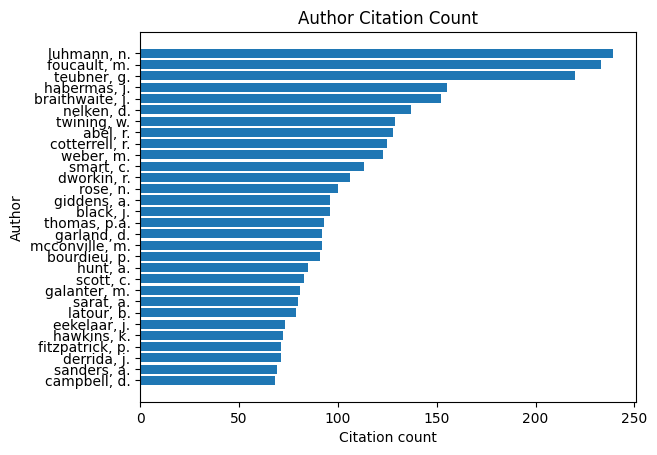

In [9]:
import matplotlib.pyplot as plt
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Author'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Author')
plt.title('Author Citation Count')
plt.savefig("docs/jls-most-cited-authors.png", bbox_inches="tight")
plt.show()

## Most-cited authors, timeseries (extraction data)

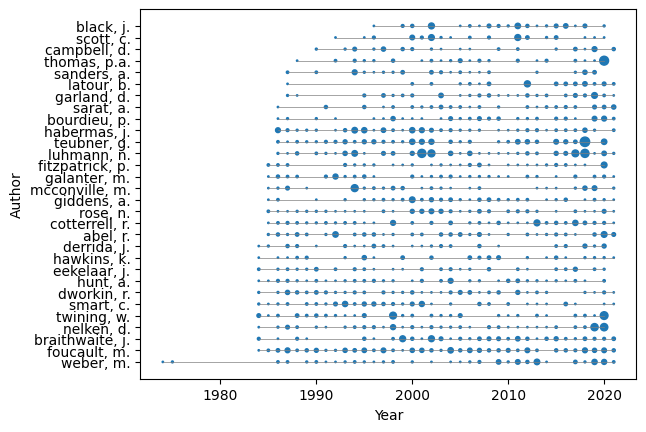

In [11]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author" and citedAuthor.display_name <> ""
with citedAuthor, count(r) as citationCount
order by citationCount desc
limit 30
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor)
RETURN citedAuthor.display_name as author,
    citingWork.year as year,
    count(r) as count
order by year
"""
from scripts.utils import get_graph
from scripts.occurrence_by_year_scatter import plot_by_year
graph = get_graph("jls2")
data = graph.run(query).to_data_frame()
plot_by_year(data, dep_col="author", dep_label="Author",
             file="figure/jls-ts-most-cited.png",
             title="")

## Most-cited journals

In [5]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
return citedVenue.name as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls2")
df = graph.run(query).to_data_frame()
df

,Journal name,Citation count
0,journal of law & society,991
1,modern law review,498
2,law & society review,417
3,social & legal studies,292
4,law rev,278
5,harvard law rev,251
6,yale law j,224
7,legal studies,223
8,criminal law review,205
9,public law,183


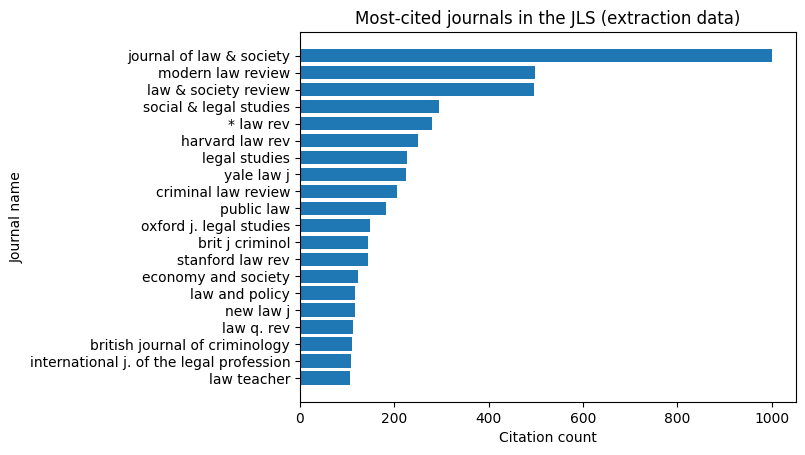

In [10]:
import matplotlib.pyplot as plt
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Most-cited journals in the JLS (extraction data)')
plt.savefig("docs/jls-most-cited-journals.png", bbox_inches="tight")
plt.show()

## Most-cited journals (WOS)

In [11]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
return toLower(citedVenue.name) as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls-journal-network")
df = graph.run(query).to_data_frame()
df

,Journal name,Citation count
0,journal of law and society,625
1,law & society review,221
2,british journal of criminology,188
3,social & legal studies,187
4,law and social inquiry-journal of the american...,119
5,yale law journal,81
6,modern law review,74
7,criminal law review,72
8,economy and society,72
9,stanford law review,69


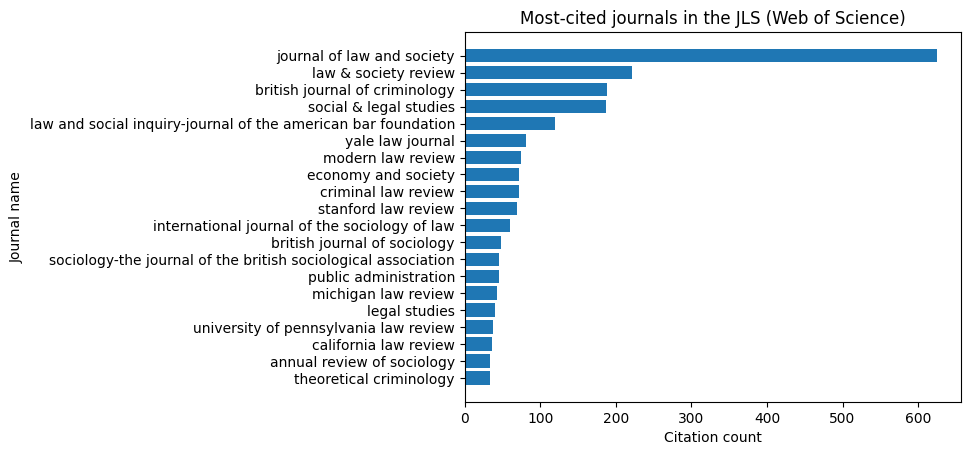

In [12]:
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Most-cited journals in the JLS (Web of Science)')
plt.savefig("docs/jls-most-cited-journals-wos.png", bbox_inches="tight")
plt.show()

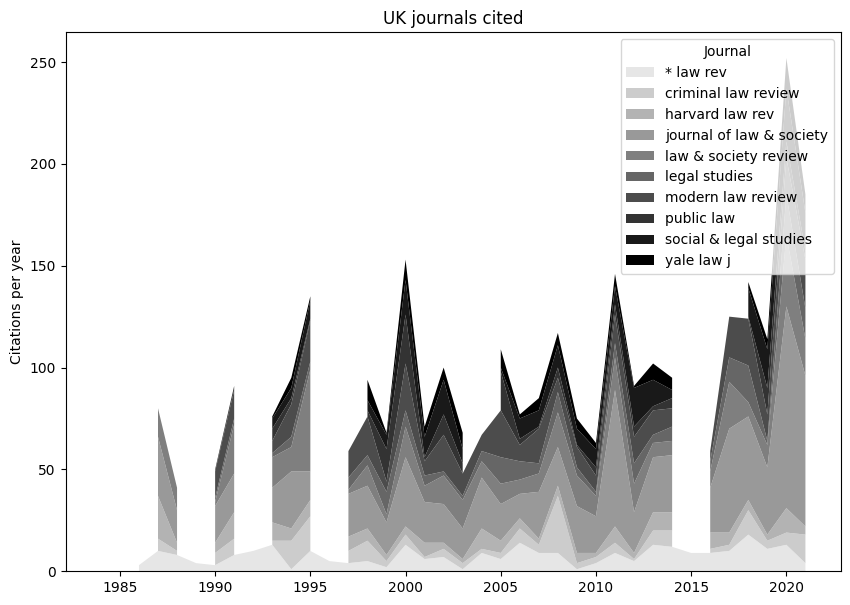

In [13]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
with toLower(citedVenue.name) as journal, count(r) as count
order by count desc
limit 10
with collect(journal) as journals
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
    and toLower(citedVenue.name) in journals
return citingWork.year as year, toLower(citedVenue.name) as `var`, count(r) as `value`
"""
from scripts.utils import get_graph
graph = get_graph("jls")
df = graph.run(query).to_data_frame()
from scripts.stacked_area_plot import plot_stacked_area
plot_stacked_area(df, var_label="Journal", value_label="Citations per year", title="UK journals cited", window_size=1)

## Most-citing journals (WOS)

In [14]:
query = """
match (citedWork:Work)<-[r:CITES]-(:Work)-[:PUBLISHED_IN]-(citingVenue:Venue)
where exists((citedWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
return toLower(citingVenue.name) as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls-journal-network")
df = graph.run(query).to_data_frame()
df

,Journal name,Citation count
0,journal of law and society,625
1,social & legal studies,312
2,british journal of criminology,120
3,modern law review,116
4,legal studies,104
5,regulation & governance,93
6,law and social inquiry-journal of the american...,88
7,law & society review,82
8,international journal of transitional justice,76
9,theoretical criminology,63


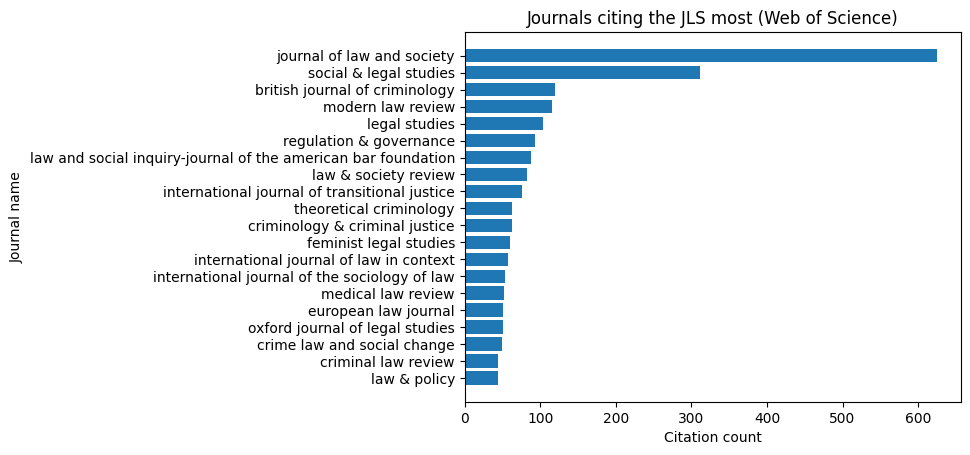

In [15]:
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Journals citing the JLS most (Web of Science)')
plt.savefig("docs/jls-most-citing-journals-wos.png", bbox_inches="tight")
plt.show()

## Journal citation network, over time (WOS)

In [1]:
query = """
with [
    'journal of law and society',
    'social & legal studies',
    'law and critique',
    'feminist legal studies',
    'international journal of law in context',
    'british journal of criminology',
    'law & society review',
    'law and social inquiry-journal of the american bar foundation'
] as journals
match  p=(citingVenue:Venue)<-[:PUBLISHED_IN]-(citingWork:Work)-[:CITES]->(:Work)-[:PUBLISHED_IN]->(citedVenue:Venue)
where toLower(citingVenue.name) in journals and toLower(citedVenue.name) in journals
    and (toLower(citingVenue.name) = 'journal of law and society' or toLower(citedVenue.name) = 'journal of law and society')
    and citingWork.year >= $year_start and citingWork.year <= $year_end
    and citingVenue <> citedVenue
with citingVenue, citedVenue, count(p) as pathCount
return citingVenue,
    citedVenue,
    apoc.create.vRelationship(citingVenue, 'CITES', {value: pathCount, label: toString(pathCount)}, citedVenue)
"""
from scripts.pyvis import create_or_update_network, draw_network
from scripts.utils import get_graph
graph = get_graph("jls-journal-network")
start_year = 1974
end_year = 2023
num_ranges = 5
file_id = "jls-socio-legal-network"
for i in range(num_ranges):
    decade_start = start_year + (i * 10)
    decade_end = decade_start + 9
    if decade_end > end_year:
        decade_end = end_year
    net = create_or_update_network(graph, query, height="600px", seed=5,
                                   year_start=decade_start, year_end=decade_end)
    url = f"figure/{file_id}-{decade_start}-{decade_end}.html"
    prev_url = f"{file_id}-{decade_start-10}-{decade_start-1}.html" if i > 0 else None
    next_url = f"{file_id}-{decade_end+1}-{decade_end+10}.html" if i < (num_ranges - 1) else None
    draw_network(net,
                 title=f"Socio-legal journal network, {decade_start} - {decade_end}",
                 prev_url=prev_url, next_url= next_url,
                 file=url, link_only=True)


## Author network (Cownie/Bradney)

In [3]:
query = """
MATCH path=(a1:Author)-[:CREATOR_OF]->(w1:Work)-[c:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.family = "cownie" OR a2.family = "cownie" or a1.family = "bradney" OR a2.family = "bradney"
    and ((w1)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}) or (w2)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
WITH a1, a2, count(c) as citations
WHERE citations >= 4
WITH collect(a1) + collect(a2) as authorNetwork, citations
UNWIND authorNetwork as authors
MATCH p2=(authors)-[:CREATOR_OF]->(:Work)-[c:CITES]->(:Work)<-[:CREATOR_OF]-(citingAuthor:Author)
WHERE citingAuthor in authorNetwork
WITH authors, citingAuthor, count(c) as citations
where authors.family <> "no_author" and citingAuthor.family <> "no_author" and authors <> citingAuthor
RETURN authors as source_node,
    apoc.create.vRelationship(authors, 'CITES', {value: citations}, citingAuthor) as rel,
    citingAuthor as target_node
"""
from scripts.pyvis import draw
from scripts.utils import get_graph
draw(get_graph("jls2"), query)